Average percent differences by model configuration:
Input: 256.0,
Hidden: 128.0,
Output: 64.0: 128.39% (n=100)
Input: 512.0,
Hidden: 256.0,
Output: 128.0: 127.53% (n=100)
Input: 1024.0,
Hidden: 512.0,
Output: 256.0: 122.71% (n=100)
Input: 2048.0,
Hidden: 1024.0,
Output: 512.0: 136.06% (n=100)

Overall Mean Percent Difference: 128.67%


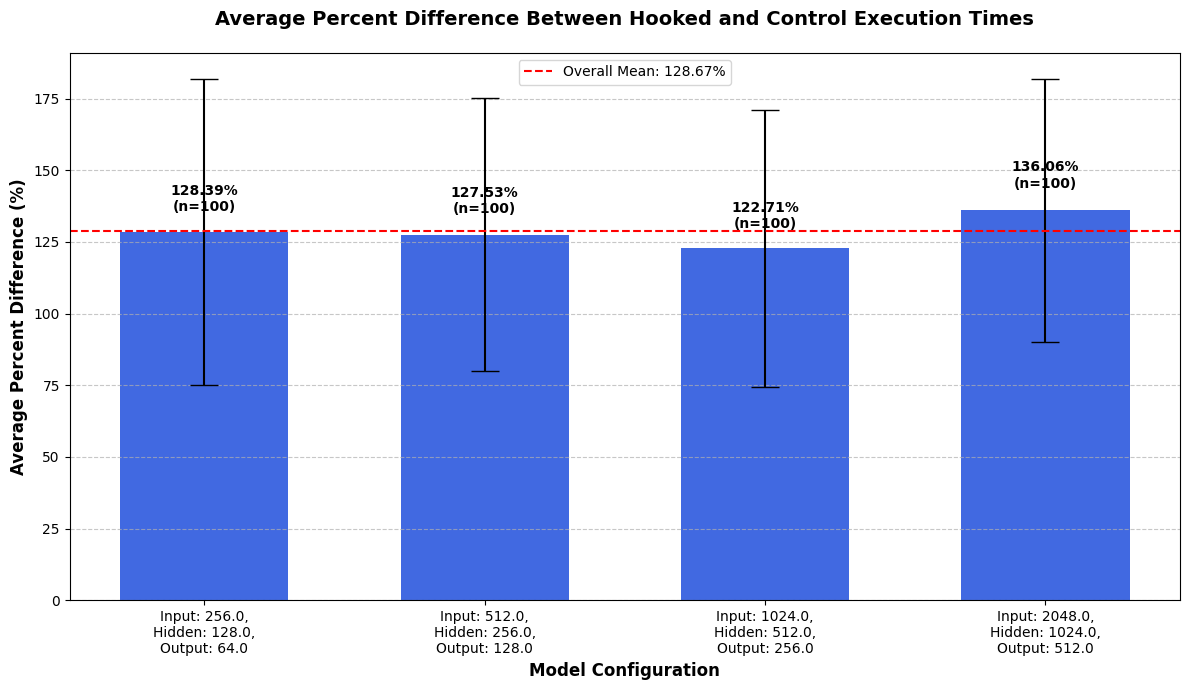

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Read the data
control_times = []
hook_times = []
model_configs = []

with open('control.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(", ")
        # Extract the model configuration and time
        input_size = int(parts[0].split(": ")[1])
        hidden_size = int(parts[1].split(": ")[1])
        output_size = int(parts[2].split(": ")[1])
        
        # Extract the mean control time
        mean_control_time = float(parts[-1].split(": ")[1].replace('s', ''))
        control_times.append(mean_control_time)
        
        # Store as a tuple for easy grouping (no batch size in this format)
        model_configs.append((input_size, hidden_size, output_size))

with open('hook.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(", ")
        # Extract the mean hooked time
        mean_hooked_time = float(parts[-1].split(": ")[1].replace('s', ''))
        hook_times.append(mean_hooked_time)

# Convert to numpy arrays
control_times = np.array(control_times)
hook_times = np.array(hook_times)

# Calculate percent differences
percent_differences = ((hook_times - control_times) / control_times) * 100

# Create a DataFrame to make aggregation easier
df = pd.DataFrame({
    'input_size': [config[0] for config in model_configs],
    'hidden_size': [config[1] for config in model_configs],
    'output_size': [config[2] for config in model_configs],
    'percent_difference': percent_differences
})

# Group by input, hidden, and output sizes
grouped_df = df.groupby(['input_size', 'hidden_size', 'output_size']).agg({
    'percent_difference': ['mean', 'std', 'count']
})

# Flatten the multi-index columns
grouped_df.columns = ['mean_diff', 'std_diff', 'count']
grouped_df = grouped_df.reset_index()

# Create model configuration labels
grouped_df['model_config'] = grouped_df.apply(
    lambda row: f"Input: {row['input_size']},\nHidden: {row['hidden_size']},\nOutput: {row['output_size']}", 
    axis=1
)

# Plot the grouped data
plt.figure(figsize=(12, 7))
bars = plt.bar(grouped_df['model_config'], grouped_df['mean_diff'], 
        yerr=grouped_df['std_diff'], capsize=10, color='royalblue', width=0.6)

# Add values on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    # Position text based on bar height to avoid overlap
    y_pos = height + max(5, height * 0.05)
    plt.text(bar.get_x() + bar.get_width() / 2, y_pos,
             f'{grouped_df["mean_diff"].iloc[i]:.2f}%\n(n={int(grouped_df["count"].iloc[i])})', 
             ha='center', va='bottom', fontweight='bold')

plt.xlabel('Model Configuration', fontsize=12, fontweight='bold')
plt.ylabel('Average Percent Difference (%)', fontsize=12, fontweight='bold')
plt.title('Average Percent Difference Between Hooked and Control Execution Times', 
          fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add overall average line
overall_mean = df['percent_difference'].mean()
plt.axhline(y=overall_mean, color='red', linestyle='--', 
            label=f'Overall Mean: {overall_mean:.2f}%')
plt.legend()

# Save plot
plt.tight_layout()
plt.savefig('average_percent_difference_plot.png')

# Show the average for each configuration
print("Average percent differences by model configuration:")
for i, row in grouped_df.iterrows():
    print(f"{row['model_config']}: {row['mean_diff']:.2f}% (n={int(row['count'])})")

# Print the overall mean
print(f"\nOverall Mean Percent Difference: {overall_mean:.2f}%")

## Takeaways 
A conventional SGD model w forward and backwards hooks is around 2.5% slower. This is a negligble overhead, telling us that hooks are not a good place to target for optimizations. Additionally, this overhead decreases as one increases the tensor sizes. Increasing the second parameter in the second linear layer from 100 to 1000 drops the percent difference to around 1.75% which can be seen in the iterations after 10. Doubling the second parameter of linear 1 from 4000 to 8000, and first param of linear 2 to the same we notice

Running experiment with Input: 1024, Hidden: 512, Output: 256


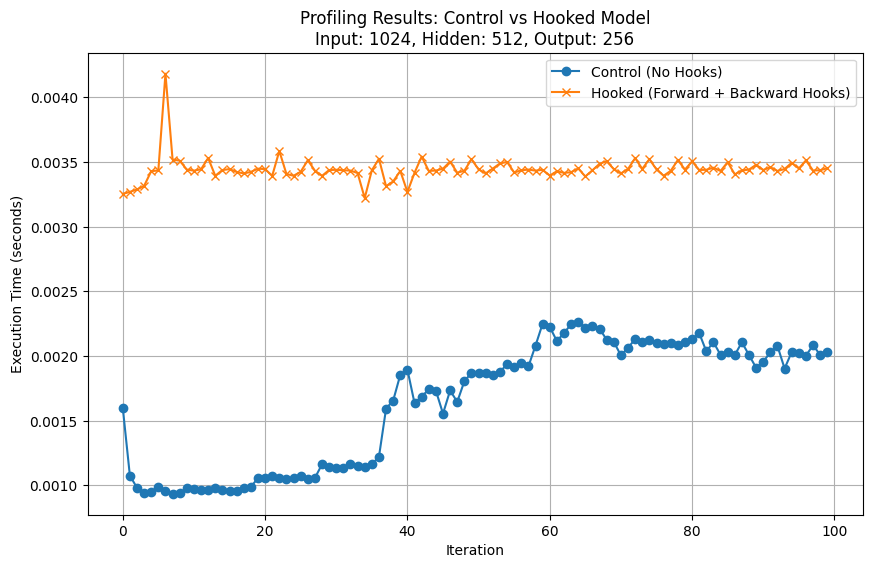

Mean Control Time: 0.001644s, Mean Hooked Time: 0.003444s

Running experiment with Input: 512, Hidden: 256, Output: 128


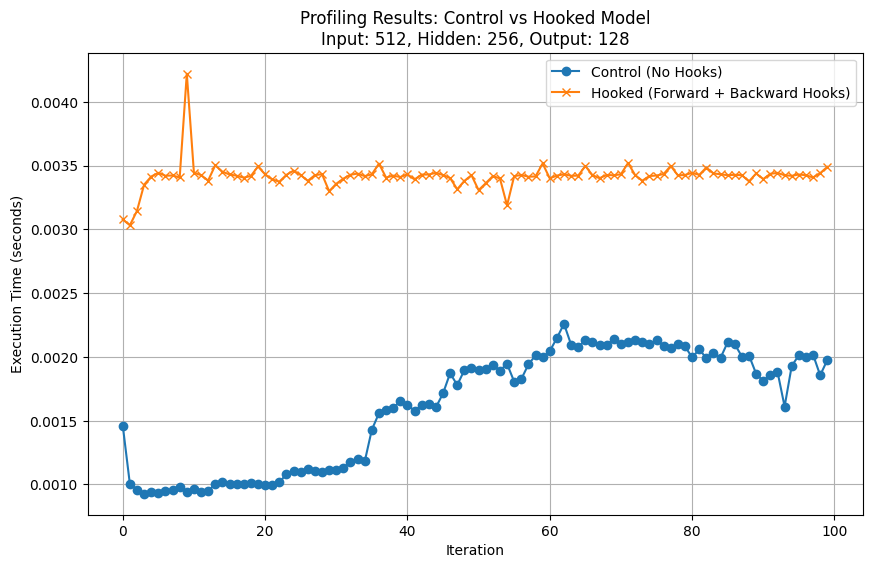

Mean Control Time: 0.001620s, Mean Hooked Time: 0.003417s

Running experiment with Input: 256, Hidden: 128, Output: 64


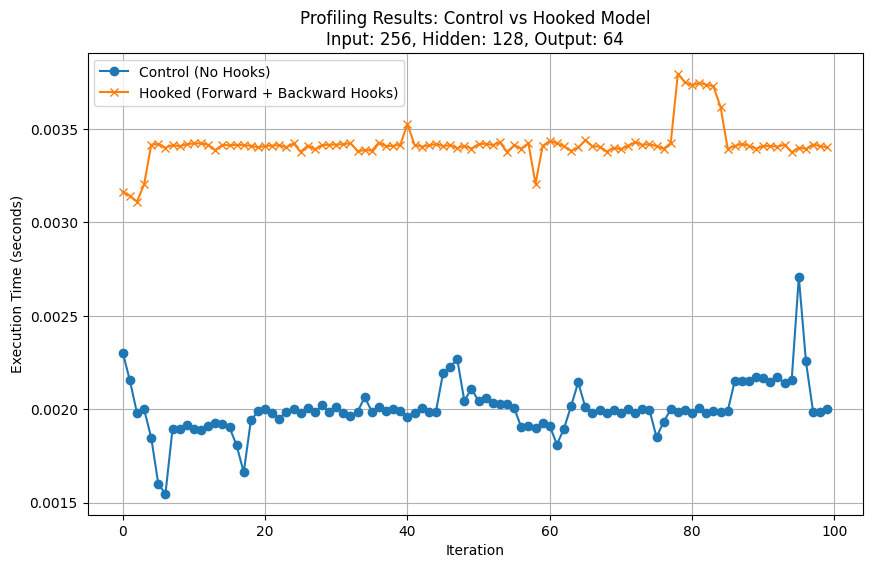

Mean Control Time: 0.002002s, Mean Hooked Time: 0.003420s

Running experiment with Input: 2048, Hidden: 1024, Output: 512


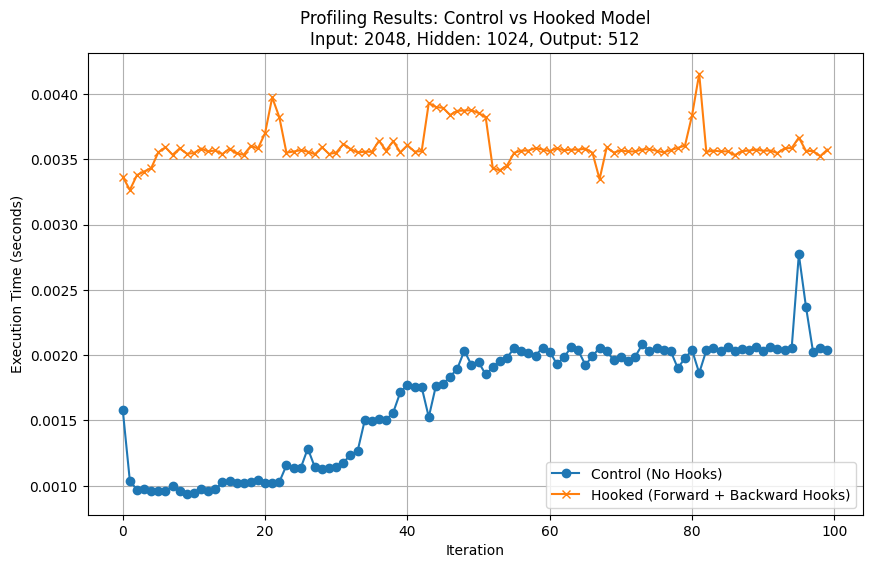

Mean Control Time: 0.001652s, Mean Hooked Time: 0.003596s



In [134]:
import torch
import torch.nn as nn
import time
import numpy as np
import matplotlib.pyplot as plt
import csv
from typing import List, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model class
class Model(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# Hook functions
def forward_hook(module, input, output):
    _ = output.mean().item()

def backward_hook(module, grad_input, grad_output, max_norm=1.0):
    total_norm = torch.norm(torch.stack([torch.norm(g) for g in grad_output if g is not None]))
    
    # Scale the gradients if the norm exceeds the max_norm
    if total_norm > max_norm:
        scale = max_norm / (total_norm + 1e-6)  # Add epsilon to avoid division by zero
        for grad in grad_output:
            if grad is not None:
                grad.mul_(scale) 

# Function to attach hooks to a model
def attach_hooks(model: nn.Module, max_norm) -> List[torch.utils.hooks.RemovableHandle]:
    hook_handles = []
    for module in model.modules():
        if isinstance(module, nn.Linear):
            hook_handles.append(module.register_forward_hook(forward_hook))
            hook_handles.append(module.register_backward_hook(lambda module, grad_input, grad_output: backward_hook(module, grad_input, grad_output, max_norm=1.0)))
    return hook_handles

# Function to remove hooks
def remove_hooks(hook_handles: List[torch.utils.hooks.RemovableHandle]):
    for handle in hook_handles:
        handle.remove()

# Function to profile a model
def profile_model(model: nn.Module, x: torch.Tensor, y: torch.Tensor, iterations: int) -> List[float]:
    times = []
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    for _ in range(iterations):
        torch.cuda.synchronize()
        start_time = time.time()

        output = model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.cuda.synchronize()
        end_time = time.time()

        times.append(end_time - start_time)
    
    return times

# Function to run experiments
def run_experiment(input_size: int, hidden_size: int, output_size: int, batch_size: int, iterations: int) -> Tuple[float, float]:
    # Initialize models
    control_model = Model(input_size, hidden_size, output_size).to(device)
    hooked_model = Model(input_size, hidden_size, output_size).to(device)

    # Attach hooks to the hooked model
    max_norm = 1.0
    hook_handles = attach_hooks(hooked_model, max_norm)

    # Generate random data
    x = torch.randn(batch_size, input_size).to(device)
    y = torch.randn(batch_size, output_size).to(device)

    # Profile models
    time_control_list = profile_model(control_model, x, y, iterations)
    time_hooked_list = profile_model(hooked_model, x, y, iterations)

    # Remove hooks
    remove_hooks(hook_handles)

    # Calculate mean times
    mean_control = np.mean(time_control_list)
    mean_hooked = np.mean(time_hooked_list)

    # Save results to files with model size information
    with open('control.txt', 'a') as f:
        f.write(f"Input: {input_size}, Hidden: {hidden_size}, Output: {output_size}, Mean Control Time: {mean_control:.6f}s\n")

    with open('hook.txt', 'a') as f:
        f.write(f"Input: {input_size}, Hidden: {hidden_size}, Output: {output_size}, Mean Hooked Time: {mean_hooked:.6f}s\n")

    # Save results to a CSV file
    with open('profiling_results.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([input_size, hidden_size, output_size, mean_control, mean_hooked])

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(range(iterations), time_control_list, label='Control (No Hooks)', marker='o')
    plt.plot(range(iterations), time_hooked_list, label='Hooked (Forward + Backward Hooks)', marker='x')
    plt.xlabel('Iteration')
    plt.ylabel('Execution Time (seconds)')
    plt.title(f'Profiling Results: Control vs Hooked Model\nInput: {input_size}, Hidden: {hidden_size}, Output: {output_size}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'profiling_results_{input_size}_{hidden_size}_{output_size}.png')
    plt.show()

    return mean_control, mean_hooked

def main():
    experiments = [
        (2**10, 2**9, 2**8, 2**7, 100),  # (input_size, hidden_size, output_size, batch_size, iterations)
        (2**9, 2**8, 2**7, 2**6, 100),
        (2**8, 2**7, 2**6, 2**5, 100),
        (2**11, 2**10, 2**9, 2**8, 100)
    ]

    for input_size, hidden_size, output_size, batch_size, iterations in experiments:
        print(f"Running experiment with Input: {input_size}, Hidden: {hidden_size}, Output: {output_size}")
        mean_control, mean_hooked = run_experiment(input_size, hidden_size, output_size, batch_size, iterations)
        print(f"Mean Control Time: {mean_control:.6f}s, Mean Hooked Time: {mean_hooked:.6f}s\n")

if __name__ == "__main__":
    main()